In [11]:
# DATAST LINK https://www.kaggle.com/datasets/kartik2112/fraud-detection

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve, auc, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
dataset = "fraudTest.csv"

In [3]:
df = pd.read_csv(dataset)

print("First few rows of the dataset:")
print(df.head())

# View the last few rows of the dataset (default is 5 rows)
print("\nLast few rows of the dataset:")
print(df.tail())

# View the summary statistics of the dataset
print("\nSummary statistics of the dataset:")
print(df.describe())

# View the column names of the dataset
print("\nColumn names of the dataset:")
print(df.columns)

# View the number of rows and columns in the dataset
print("\nNumber of rows and columns in the dataset:")
print(df.shape)

First few rows of the dataset:
   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2020-06-21 12:14:25  2291163933867244   
1           1   2020-06-21 12:14:33  3573030041201292   
2           2   2020-06-21 12:14:53  3598215285024754   
3           3   2020-06-21 12:15:15  3591919803438423   
4           4   2020-06-21 12:15:17  3526826139003047   

                               merchant        category    amt   first  \
0                 fraud_Kirlin and Sons   personal_care   2.86    Jeff   
1                  fraud_Sporer-Keebler   personal_care  29.84  Joanne   
2  fraud_Swaniawski, Nitzsche and Welch  health_fitness  41.28  Ashley   
3                     fraud_Haley Group        misc_pos  60.05   Brian   
4                 fraud_Johnston-Casper          travel   3.19  Nathan   

       last gender                       street  ...      lat      long  \
0   Elliott      M            351 Darlene Green  ...  33.9659  -80.9355   
1  Williams      F             

In [4]:
# Checking for missing values in the dataset
print(df.isnull().sum())


df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], format='%Y/%m/%d %H:%M')

# Converting "trans_date_trans_time" to day, hour, minute and second format
df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
df['hour_of_day'] = df['trans_date_trans_time'].dt.hour
df['minute_of_hour'] = df['trans_date_trans_time'].dt.minute
df['second_of_minute'] = df['trans_date_trans_time'].dt.second

# Dropping the original 'trans_date_trans_time' column as we have already converted it to 
# a date-time object from pandas lib instead of its default being a string
df.drop('trans_date_trans_time', axis=1, inplace=True)

# Using LabelEncoder to convert categorical variables to numerical labels
# to avoid possible issues with algorithms only supporting numerical data,
# for example Logistic regression, Naive Bayes, K-NN
label_encoder = LabelEncoder()
df['merchant'] = label_encoder.fit_transform(df['merchant'])
df['category'] = label_encoder.fit_transform(df['category'])
df['gender'] = label_encoder.fit_transform(df['gender'])
df['job'] = label_encoder.fit_transform(df['job'])

# Scaling Numerical Features
# Standardize Standerdizing them to a range of mean 0 to variance 1
scaler = StandardScaler() # the function calculates standardize valuse z = x-mean/standard deviation
numerical_features = ['amt', 'lat', 'long', 'city_pop', 'unix_time', 'merch_lat', 'merch_long',
                      'day_of_week', 'hour_of_day', 'minute_of_hour', 'second_of_minute']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Sort the DataFrame by the day, hour, minute and seconf to maintain time order
df_sorted = df.sort_values(by=['day_of_week', 'hour_of_day', 'minute_of_hour', 'second_of_minute'])

# Cleaning dataset of non numerical columns and columns that shouldnt effect the model
# Also dropping cc_num because it is a catagorical column and shouldn't serve any purpose 
# in training the model. Dropping column 'Unnamed: 0' as it is 
# basically an unnecessary extra indexing caulumn created in the dataset and it throws 
#exceptions running following code
columns_to_drop = ['Unnamed: 0','cc_num', 'trans_num', 'street', 'city', 'state', 'zip', 'job', 'dob', 'first', 'last']
df_sorted = df_sorted.drop(columns_to_drop, axis=1)

# Display the first few rows of the cleaned DataFrame
print(df_sorted.head())

# Reset the index of the sorted data frame to maintain a sequential order
df_sorted = df_sorted.reset_index(drop=True)

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64
        merchant  category       amt  gender       lat      long  city_pop  \
180985       438        12 -0.393202       0 -0.535838 -0.283300 -0.284416   
218265       674         9 -0.417637       0  0.494721  0.759554 -0.293228   
121662       543         4  0.391380       0  0.597737  0.500528 -0.292795   
282481        77         2  0.046044       0  0.204896

Number of outliers detected using Isolation Forest: 54200


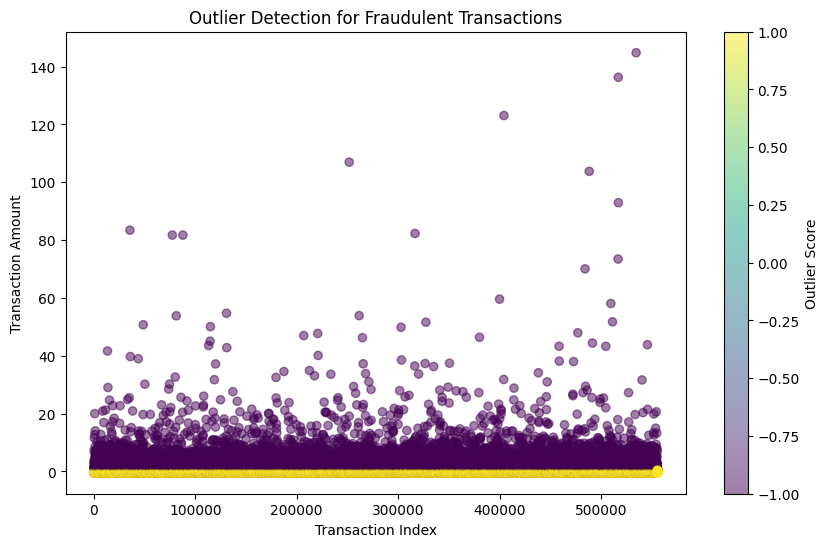

In [5]:
# Using Isolation forest to visualise ouliers in the dataset
# Extract the 'amt' and 'is_fraud' columns for outlier detection
# CHOOSING ORIGINAL DATASET TO SHOW THE OUTLIERS as we want to see the outliers in the original dataset
X_outliers = df[['amt']] #feature to detect outl;iers
y_outliers = df['is_fraud'] #feature to validate

# Create an Isolation Forest model for outlier detection
# Create an instance of the Isolation Forest model for outlier detection.
# The 'contamination' parameter is set to 'auto', which will automatically determine 
# the fraction of outliers in the dataset. The 'random_state' is set for reproducibility.
outlier_model = IsolationForest(contamination='auto', random_state=42)
# Fit the Isolation Forest model on the data. This trains the model to understand the 
# data distribution and identify potential outliers.
outlier_model.fit(X_outliers)

# Fit the model to the data and predict outliers
outlier_preds = outlier_model.fit_predict(X_outliers)
# Count and display the outliers
outlier_count = (outlier_preds == -1).sum()
# Displaying the number of detected outliers to the console.
print(f"Number of outliers detected using Isolation Forest: {outlier_count}")

# Optional: Display the actual outlier rows
# outlier_rows = df[outlier_preds == -1]
# print(outlier_rows)

# Create a new DataFrame with predicted outlier labels
# Create a copy of the original dataframe and add a new column 'outlier' which
# contains the predicted outlier labels from the Isolation Forest model.
outliers_df = df.copy()
df['outlier'] = outlier_preds

# Plotting the data: Each point represents a transaction with its index on the x-axis
# and its amount on the y-axis. Points are colored based on whether they're predicted 
# as outliers or not, using the 'outlier' column.
plt.figure(figsize=(10, 6))
plt.scatter(df.index, df['amt'], c=df['outlier'], cmap='viridis', alpha=0.5)
# Add a colorbar to the plot to show the meaning of colors (outlier or inlier).
plt.colorbar(label='Outlier Score')
# Setting the title and axis labels for the plot.
plt.title('Outlier Detection for Fraudulent Transactions')
plt.xlabel('Transaction Index')
plt.ylabel('Transaction Amount')
# Display the plot.
plt.show()



In [6]:
# Using the Function to detect detect_outliers_z_score to 
# Define a function to detect outliers in a given dataset using the Z-score method.
# The Z-score represents the number of standard deviations a data point is from the mean.
# Values with a Z-score greater than the threshold (default is 3) are considered outliers.
def detect_outliers_z_score(data, threshold=3):
    z_scores = np.abs((data - data.mean()) / data.std())
    return z_scores > threshold

# Define the numerical columns on which to check for outliers
numerical_columns = ['amt', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long']

# Checking for outliers in each numerical column by calling the function "detect_outliers_z_score"  
# with parameter "numerical_columns" initialising it to variable "outliers"
outliers = detect_outliers_z_score(df_sorted[numerical_columns])

# Count the number of outliers in each column
num_outliers = outliers.sum()



print("Number of outliers in each column:")
print(num_outliers)

# Print the ORIGINAL DataFrame to see rows with outliers
rows_with_outliers = df[outliers.any(axis=1)]
print("Rows with outliers:")
print(rows_with_outliers)#SHOWS 27 ROWS SINCE "trans_date_trans_time" HAS BEEN DEVIDED UP IN 3 SECTIONS TO FIT DAY,HOUR, MINUTE, SECOND FORMAT

Number of outliers in each column:
amt            5115
lat            1933
long           1933
city_pop      14046
merch_lat      1933
merch_long     1933
dtype: int64
Rows with outliers:
        Unnamed: 0               cc_num  merchant  category       amt  \
18              18  4861310130652566408       437         0  0.068373   
27              27     3577663406369449       366        10 -0.428865   
49              49      377026671291680       180         5 -0.408514   
96              96     5501083170975659       313         1 -0.340250   
176            176  4810839835482794272       546         7  0.167642   
...            ...                  ...       ...       ...       ...   
555581      555581        4681699462969       418         1 -0.365514   
555588      555588         630423337322       454        12 -0.416999   
555606      555606        4613314721966       254        10  0.004703   
555641      555641  4989847570577635369       349        12 -0.394351   
555688   

Percentage of fraudulent transactions: 0.39%
Total Fraudulant Transactions: 2145.00
Total Transactions: 553574.00


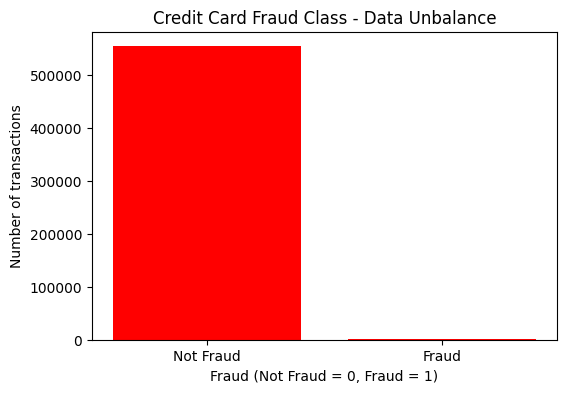

In [7]:
# Data Balancing - Here Visualising data imbalance (huge Imbalance as fraud amount is very low)
# VISUALISING DISBALANCE IN ORIGINAL DATAFRAME
# Get the count of each class (fraudulent and non-fraudulent transactions)
temp = df['is_fraud'].value_counts()

# Create a DataFrame for plotting
imb_df = pd.DataFrame({'Fraud': temp.index, 'Number of transactions': temp.values})

# Print the number of fraudulent transactions
total_transactions = temp.sum()
percentage_frauds = (temp[1] / total_transactions) * 100

# Print the percentage of fraudulent transactions
print("Percentage of fraudulent transactions: {:.2f}%".format(percentage_frauds))
print("Total Fraudulant Transactions: {:.2f}".format(temp[1]))
print("Total Transactions: {:.2f}".format(temp[0]))

# Plot the bar chart
plt.figure(figsize=(6, 4))
plt.bar(imb_df['Fraud'], imb_df['Number of transactions'], color='red')
plt.xlabel('Fraud (Not Fraud = 0, Fraud = 1)')
plt.ylabel('Number of transactions')
plt.title('Credit Card Fraud Class - Data Unbalance')
plt.xticks(imb_df['Fraud'], ['Not Fraud', 'Fraud'])
plt.show()

In [8]:
# print(df_sorted)

# Dropping "is_fraud" so the machine learning models can't know which transaction is farud by default
# to make it the input feature for the algorithms
# It is to not let the machine learning algorithm to cheat
X = df_sorted.drop('is_fraud', axis=1) 
# Setting "is_fraud" to y to make it the target variable for this model
y = df_sorted['is_fraud']

# Apply SMOTE to oversample the minority class as we saw previously the imbalance in legitimate and
# fraudulant transactions is very large making the data very imbalance.
# Best result for log reg at os ratio 1, for Random Forest 0.7, for Gradient Boosting 1,
smote = SMOTE(sampling_strategy= 1, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the resampled data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Logistic Regression

In [136]:
#Logistic regression
# Create a Logistic Regression model
logreg_model = LogisticRegression()

# Train the model
logreg_model.fit(X_train, y_train)

# Predict on the test set
y_pred = logreg_model.predict(X_test)

# Evaluate model on training data to check for overfitting
y_train_pred_logReg = logreg_model.predict(X_train)

print("Logistic Regression training Data Performance:")
print(classification_report(y_train, y_train_pred_logReg))

# Print classification report
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred))

C:\Users\BooolZay\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression training Data Performance:
              precision    recall  f1-score   support

           0       0.81      0.91      0.86    443219
           1       0.90      0.79      0.84    442499

    accuracy                           0.85    885718
   macro avg       0.85      0.85      0.85    885718
weighted avg       0.85      0.85      0.85    885718

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.91      0.86    110355
           1       0.90      0.79      0.84    111075

    accuracy                           0.85    221430
   macro avg       0.85      0.85      0.85    221430
weighted avg       0.85      0.85      0.85    221430



[[109684    671]
 [ 56426  54649]]


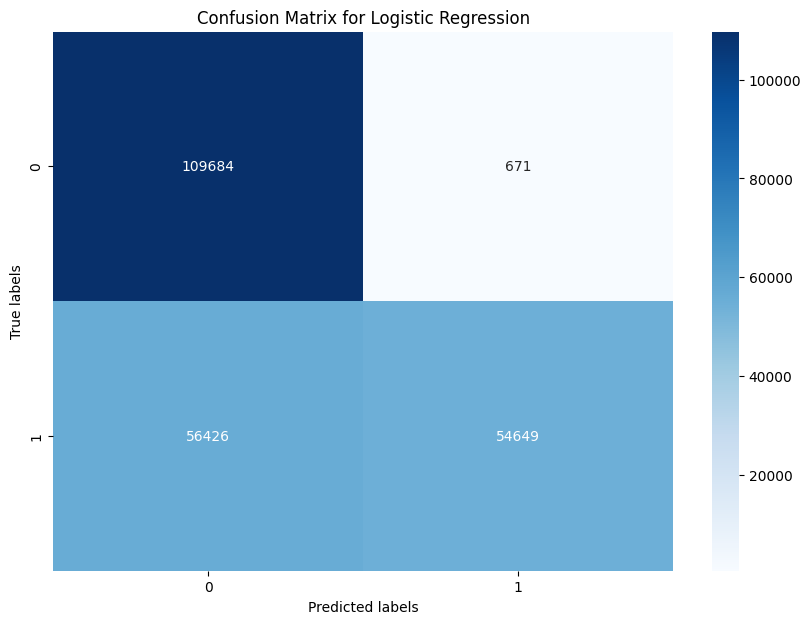

In [124]:
# Confusion matrix plot
# Predicting using Logistic Regression model
y_pred_logreg = logreg_model.predict(X_test)  # Using the provided Logistic Regression model

conf_matrix = confusion_matrix(y_test, y_pred_logreg)
print(conf_matrix)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()


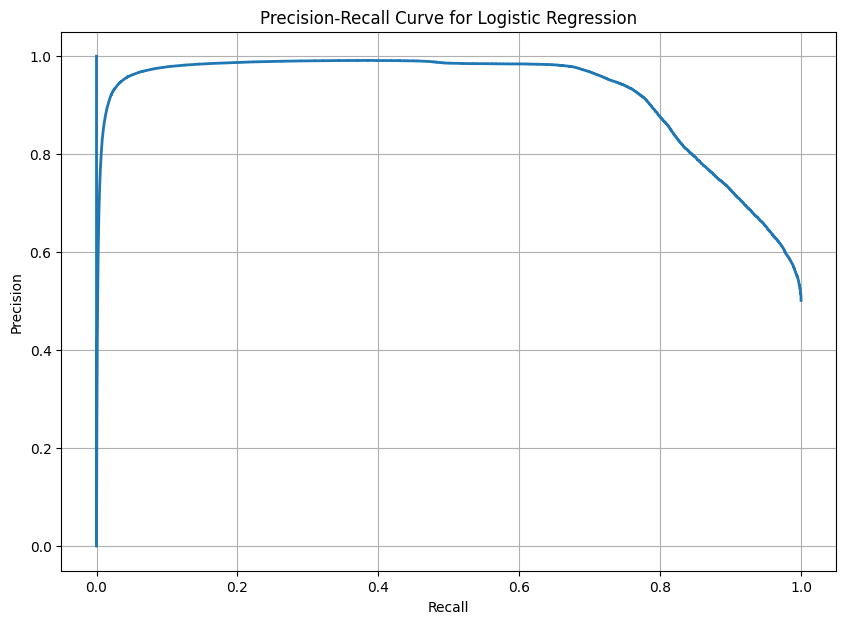

In [11]:
logReg_y_prob = logreg_model.predict_proba(X_test)[:, 1]  # Getting the probabilities for the positive class

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, logReg_y_prob)

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 7))
plt.plot(recall, precision, lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Logistic Regression')
plt.grid()
plt.show()

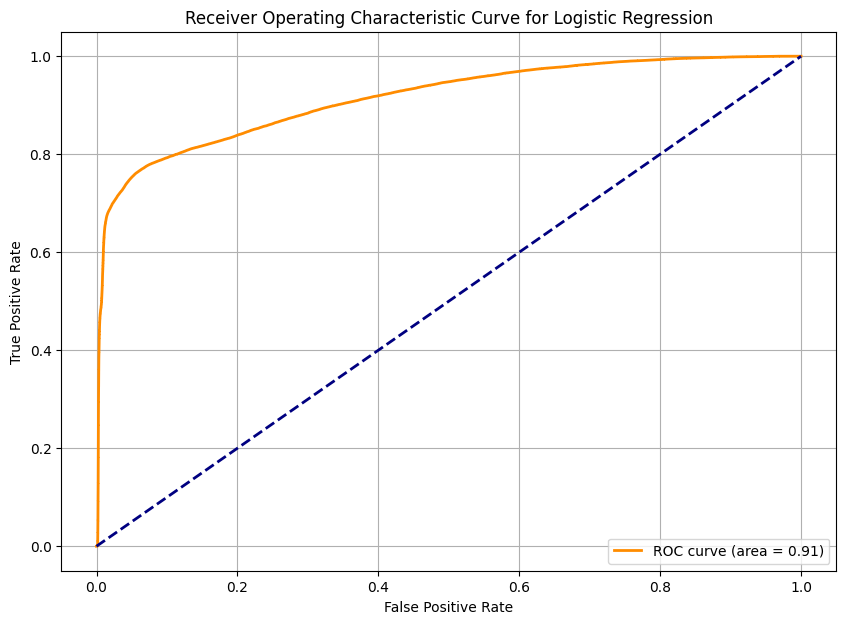

In [12]:


logReg_fpr, logReg_tpr, _ = roc_curve(y_test, logReg_y_prob)
logReg_roc_auc = auc(logReg_fpr, logReg_tpr)

plt.figure(figsize=(10, 7))
plt.plot(logReg_fpr, logReg_tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % logReg_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# New transaction for prediction

In [9]:
# Hypothetical new transaction data (unseen data)
new_transaction = {
    'merchant': 800, # A marchent number betweel 1-800 as specified in the data's description
    'category': 12, # assuming a category
    'amt': 250.75,  # assuming an amount
    'gender': 0, 
    'lat': 34.0522,  # Latitude for Los Angeles, CA
    'long': -118.2437,  # Longitude for Los Angeles, CA
    'city_pop': 3792621,  # Population of Los Angeles, CA
    'unix_time': 1677668800,  # Just an example timestamp
    'merch_lat': 34.0527,  # slightly different latitude for the merchant's location
    'merch_long': -118.2458,  # slightly different longitude for the merchant's location
    'day_of_week': 3,  # Wednesday, if considering 0 = Sunday
    'hour_of_day': 14,  # 2 PM
    'minute_of_hour': 35,  # 35th minute
    'second_of_minute': 15  # 15th second
}

# Convert the new transaction data to a DataFrame
# ... (Your code up to defining new_transaction)

# Convert the new transaction data to a DataFrame
new_data = pd.DataFrame([new_transaction])

# Scale the numerical features using the same scaler used for training
new_data[numerical_features] = scaler.transform(new_data[numerical_features])

# Cross Validation for Logistic Regression

In [97]:
# Cross-validating the Logistic regression algorithm at oversampling rate 1
cross_val_scores_logReg = cross_val_score(logreg_model, X_train, y_train, cv=5, scoring='accuracy')
print("\nCross Validation Scores:", cross_val_scores_logReg)
print("Mean Cross Validation Score:", cross_val_scores_logReg.mean())

# Make predictions using the trained logistic regression model
predicted_class = logreg_model.predict(new_data)
print(predicted_class)
# Mapping the predicted class to label fraud or not fraud
predicted_label_logreg = 'Fraud' if predicted_class[0] == 1 else 'Not Fraud'
# Print the prediction result
print("Predicted Label for the New Transaction:", predicted_label_logreg)

C:\Users\BooolZay\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\BooolZay\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin


Cross Validation Scores: [0.94750023 0.94693572 0.94823923 0.9481058  0.94887507]
Mean Cross Validation Score: 0.9479312091370469
[0]
Predicted Label for the New Transaction: Not Fraud


C:\Users\BooolZay\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


There seens to be no overfitting of the data as the training data performs almost if not the same as the test data as understood by this article:
https://aws.amazon.com/what-is/overfitting/#:~:text=Overfitting%20is%20an%20undesirable%20machine,on%20a%20known%20data%20set.

# Random Forest

In [10]:
#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Defining the model
rf = RandomForestClassifier(n_estimators=150, max_depth=10, min_samples_split=100, random_state = 42)
# Fit the model
rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf.predict(X_test)

# Evaluate model on training data to check for overfitting
y_train_pred_rf = rf.predict(X_train)

print("Random forest Training Data Performance:")
print(classification_report(y_train, y_train_pred_rf))

# Print classification report
print("Classification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf))

Random forest Training Data Performance:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95    443219
           1       0.97      0.93      0.95    442499

    accuracy                           0.95    885718
   macro avg       0.95      0.95      0.95    885718
weighted avg       0.95      0.95      0.95    885718

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95    110355
           1       0.97      0.93      0.95    111075

    accuracy                           0.95    221430
   macro avg       0.95      0.95      0.95    221430
weighted avg       0.95      0.95      0.95    221430



# Cross Validation for Random Forest

In [ ]:
# Cross-validating the Logistic regression algorithm at oversampling rate 1
cross_val_scores_logReg = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
print("\nCross Validation Scores:", cross_val_scores_logReg)
print("Mean Cross Validation Score:", cross_val_scores_logReg.mean())

# Predict using the Gradient Boosting model
predicted_class_rf = rf.predict(new_data)
# Map the predicted class to a meaningful label (fraud or not fraud)
predicted_label_rf = 'Fraud' if predicted_class_rf[0] == 1 else 'Not Fraud'
print("\nPredicted Label for the New Transaction using Random Forest:", predicted_label_rf)

[[107429   2926]
 [  7846 103229]]


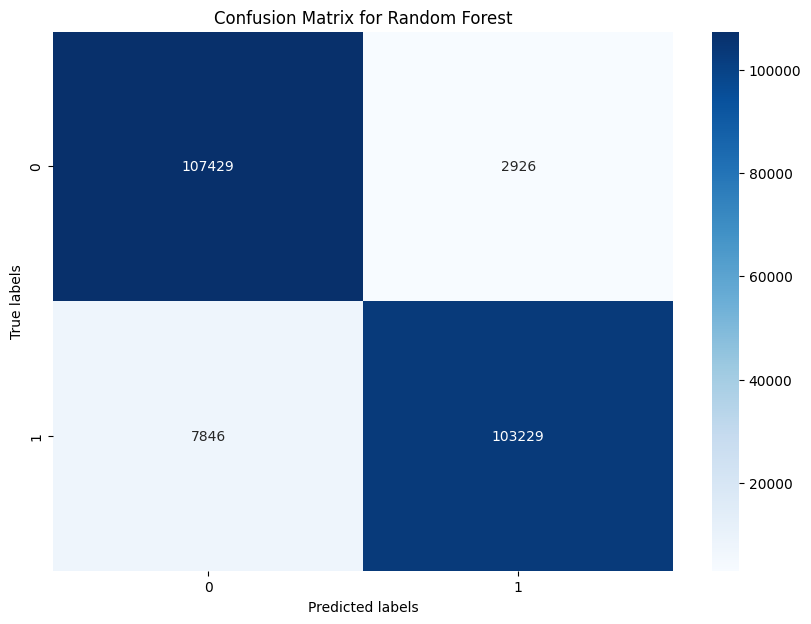

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred_rf = rf.predict(X_test)  # Assuming you have already predicted the results using Random Forest

conf_matrix = confusion_matrix(y_test, y_pred_rf)
print(conf_matrix)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Random Forest')
plt.show()


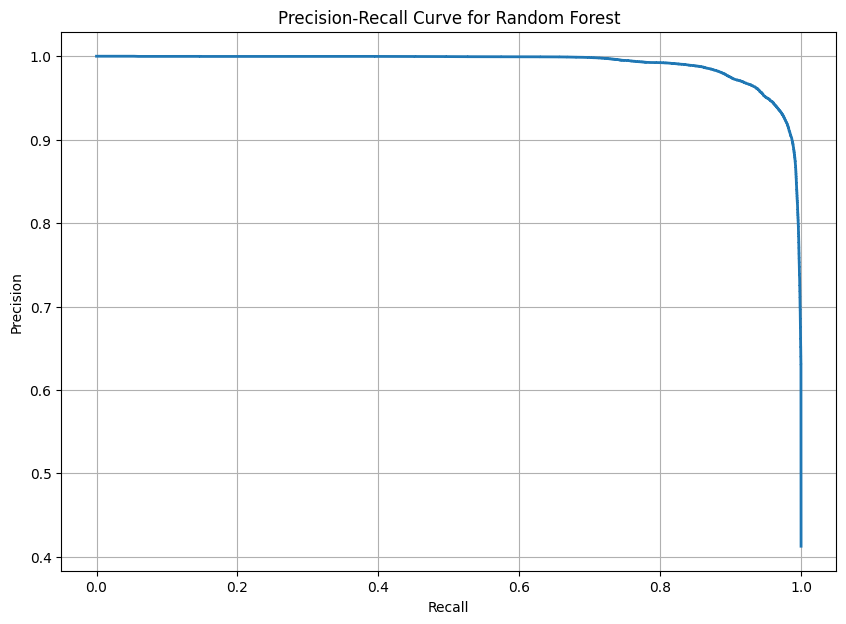

In [143]:
#Precision-Recall Curve
from sklearn.metrics import precision_recall_curve

y_prob = rf.predict_proba(X_test)[:, 1]  # Assuming your model can provide probabilities

precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(10, 7))
plt.plot(recall, precision, lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Random Forest')
plt.grid()
plt.show()


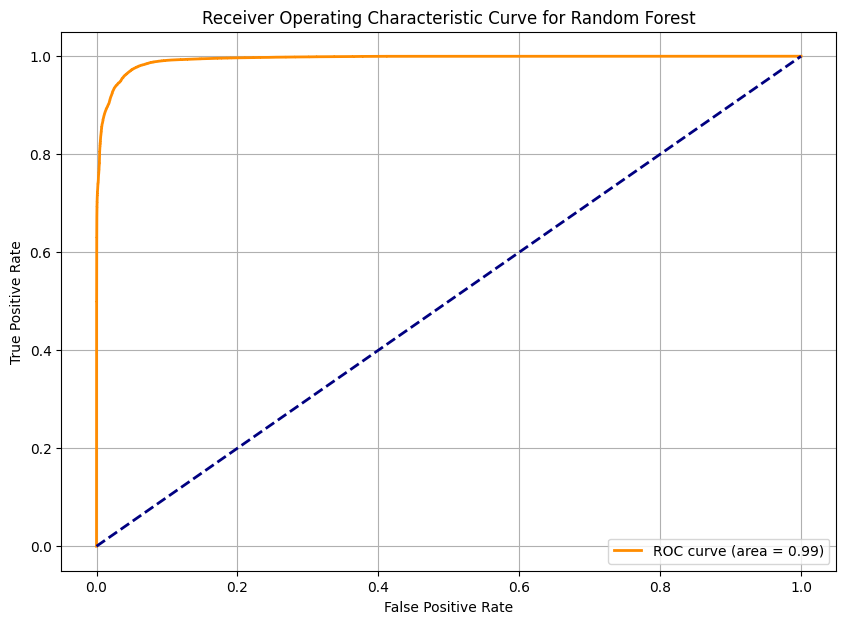

In [144]:
#ROC
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve for Random Forest')
plt.legend(loc='lower right')
plt.grid()
plt.show()



# Gradient Boosting

In [138]:

# Initialize the GradientBoostingClassifier with some tweaks
gb_model = GradientBoostingClassifier(
    n_estimators=150,
    learning_rate=0.05,
    max_depth=2,
    subsample=0.8,
    random_state=42
)

# Train the model using the resampled training data
gb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_gb = gb_model.predict(X_test)

# Evaluate model on training data to check for overfitting
y_train_pred_gb = gb_model.predict(X_train)

print("Gradient Boosting Training Data Performance:")
print(classification_report(y_train, y_train_pred_gb))

# Print classification report for test data
print("\nGradient Boosting Test Data Performance:")
print(classification_report(y_test, y_pred_gb))

# Confusion matrix
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
print("Confusion Matrix:\n", conf_matrix_gb)



Gradient Boosting Training Data Performance:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94    443219
           1       0.97      0.91      0.94    442499

    accuracy                           0.94    885718
   macro avg       0.94      0.94      0.94    885718
weighted avg       0.94      0.94      0.94    885718


Gradient Boosting Test Data Performance:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94    110355
           1       0.97      0.91      0.94    111075

    accuracy                           0.94    221430
   macro avg       0.94      0.94      0.94    221430
weighted avg       0.94      0.94      0.94    221430

Confusion Matrix:
 [[107171   3184]
 [ 10015 101060]]


# Cross Validation for gradiant boosting model

In [139]:
# Cross-validating the gradient boosting algorithm
cross_val_scores_gb = cross_val_score(gb_model, X_train, y_train, cv=5, scoring='accuracy')
print("\nCross Validation Scores:", cross_val_scores_gb)
print("Mean Cross Validation Score:", cross_val_scores_gb.mean())

# Predict using the Gradient Boosting model
predicted_class_gb = gb_model.predict(new_data)

# Map the predicted class to a meaningful label (fraud or not fraud)
predicted_label_gb = 'Fraud' if predicted_class_gb[0] == 1 else 'Not Fraud'
print("\nPredicted Label for the New Transaction using Gradient Boosting:", predicted_label_gb)

KeyboardInterrupt: 

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns

# Your cross-validation scores
cv_scores_gb = cross_val_scores_gb

# Setting the style of seaborn plot
sns.set_style("whitegrid")

# Creating a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(y=cv_scores_gb)

# Adding titles and labels
plt.title('Cross Validation Scores', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Gradient Boosting Classifier', fontsize=14)

# Display the plot
plt.show()


NameError: name 'cross_val_scores' is not defined

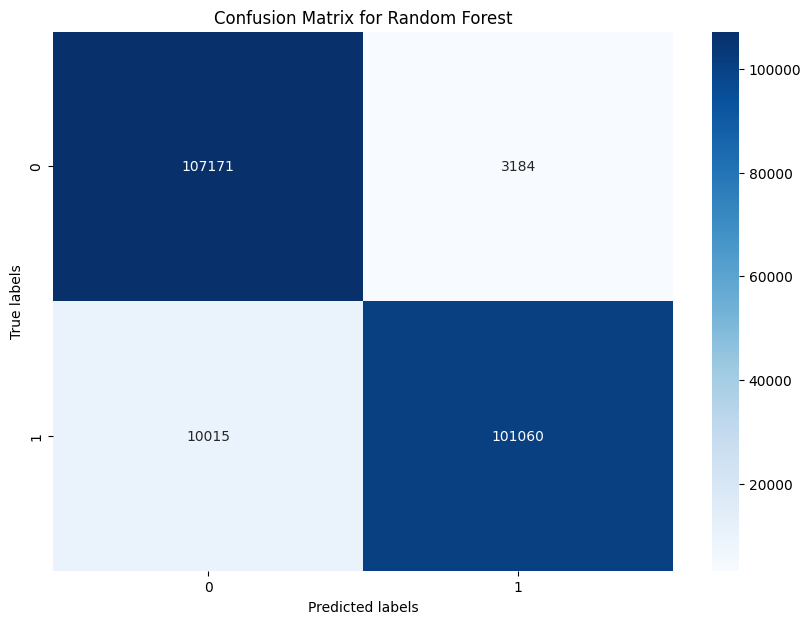

In [20]:
#y_pred_gb = gb_model.predict(X_test)  # Assuming you have already predicted the results using Random Forest

conf_matrix = confusion_matrix(y_test, y_pred_gb)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Random Forest')
plt.show()


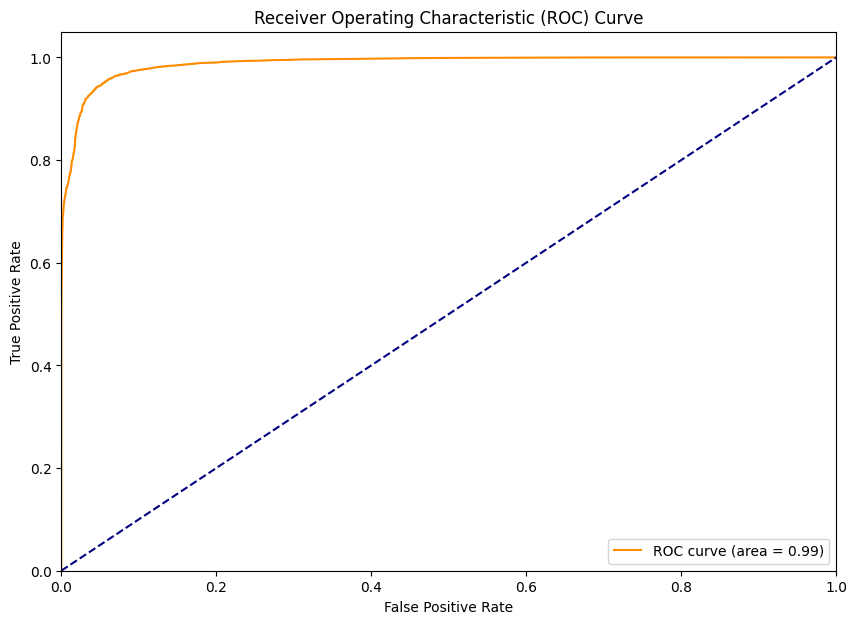

In [21]:
# Get the prediction probabilities
y_pred_prob_gb = gb_model.predict_proba(X_test)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_gb)

# Compute the AUC
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


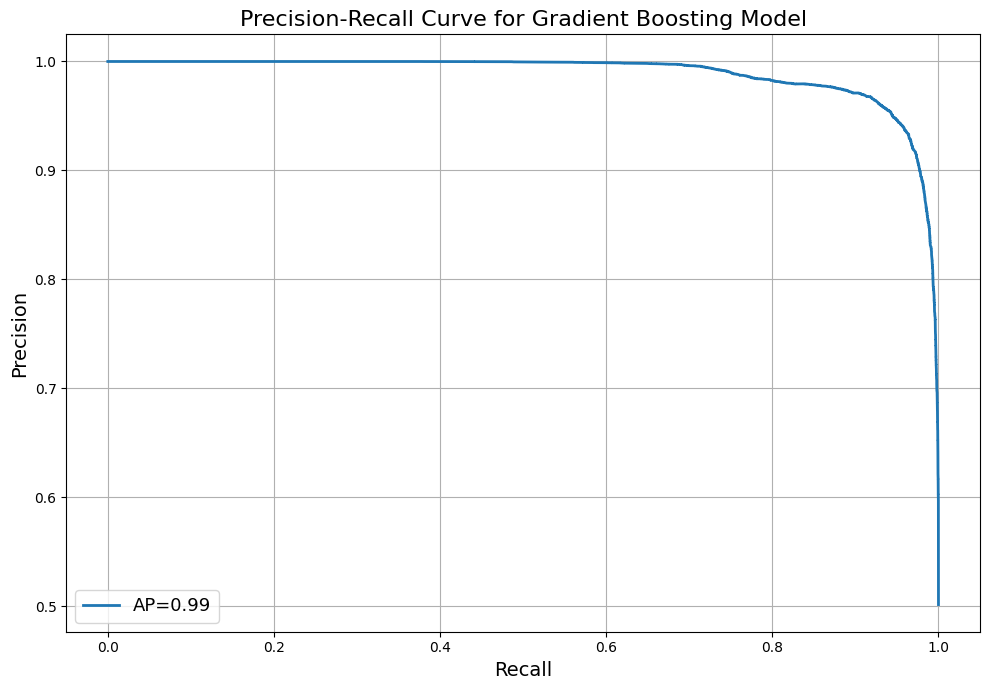

In [22]:
# Get the probability scores for the positive class
from sklearn.metrics import average_precision_score
y_scores_gb = gb_model.predict_proba(X_test)[:, 1]

# Compute precision-recall curve values
precision, recall, _ = precision_recall_curve(y_test, y_scores_gb)

# Compute the average precision score
avg_precision = average_precision_score(y_test, y_scores_gb)

# Plot the precision-recall curve
plt.figure(figsize=(10, 7))
plt.plot(recall, precision, label=f'AP={avg_precision:.2f}', lw=2)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve for Gradient Boosting Model', fontsize=16)
plt.legend(loc='lower left', fontsize=13)
plt.grid(True)
plt.tight_layout()
plt.show()

# Gaussian Naive Bayes

In [59]:
#Naive BAYSE
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix

# Initialize the Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Train the model using the training data
gnb.fit(X_train, y_train)

# Predict on the test set
y_pred_nb = gnb.predict(X_test)

# Evaluate model on training data to check for overfitting
y_train_pred_gnb = gnb.predict(X_train)

print("Gaussian Naive Bayes Training Data Performance:")
print(classification_report(y_train, y_train_pred_gnb))

# Print classification report for the test set
print("Gaussian Naive Bayes Classification Report (Test Data):")
print(classification_report(y_test, y_pred_nb))

# Confusion matrix for the test set
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)
print("Confusion Matrix (Test Data):\n", conf_matrix_nb)

# If you have a new_data sample to predict, you can use:
predicted_class_nb = gnb.predict(new_data)
predicted_label_nb = 'Fraud' if predicted_class_nb[0] == 1 else 'Not Fraud'
print("Predicted Label for the New Transaction using Naive Bayes:", predicted_label_nb)


Gaussian Naive Bayes Training Data Performance:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    442985
           1       0.82      0.51      0.63     44159

    accuracy                           0.95    487144
   macro avg       0.89      0.75      0.80    487144
weighted avg       0.94      0.95      0.94    487144

Gaussian Naive Bayes Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.95      0.99      0.97    110589
           1       0.82      0.52      0.63     11198

    accuracy                           0.95    121787
   macro avg       0.89      0.75      0.80    121787
weighted avg       0.94      0.95      0.94    121787

Confusion Matrix (Test Data):
 [[109339   1250]
 [  5414   5784]]
Predicted Label for the New Transaction using Naive Bayes: Not Fraud


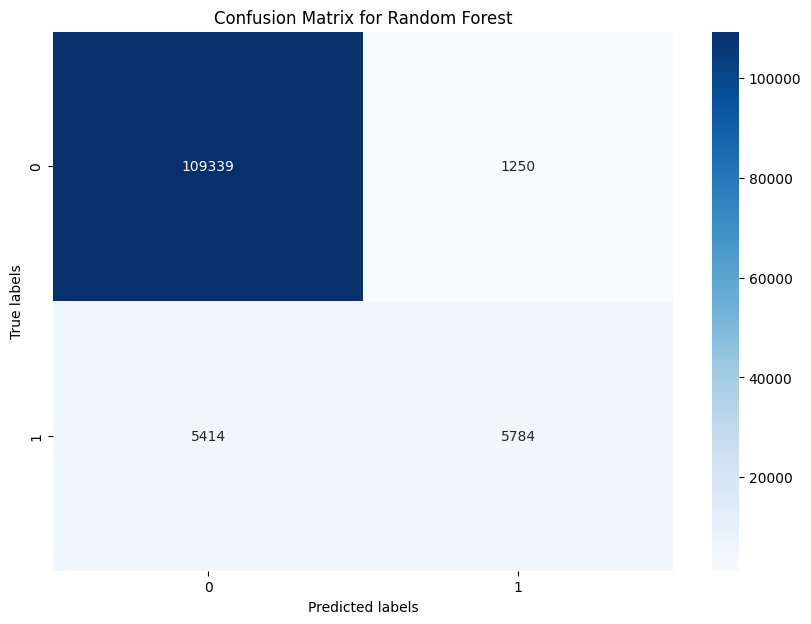

In [40]:

conf_matrix = confusion_matrix(y_test, y_pred_nb)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Random Forest')
plt.show()

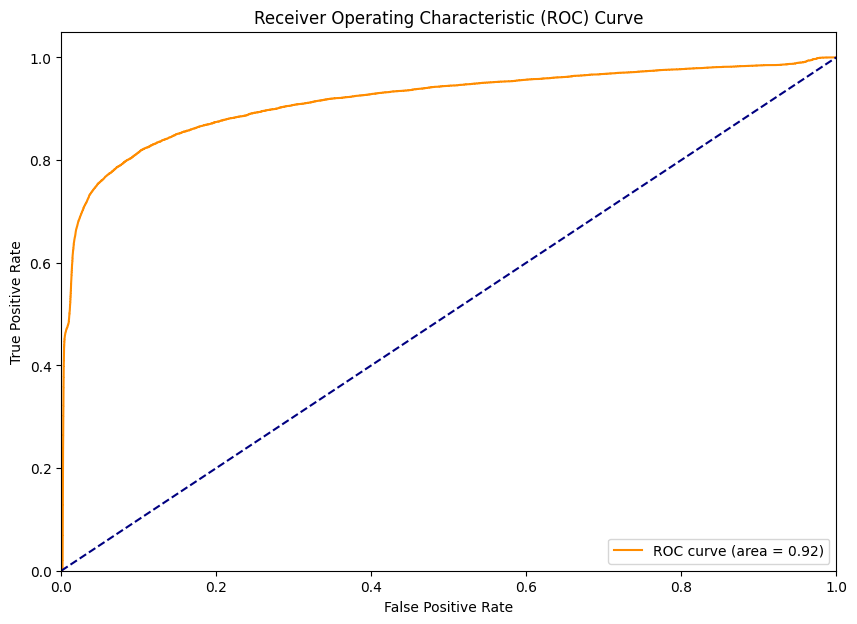

In [41]:
# Get the prediction probabilities
y_pred_prob_nb = gnb.predict_proba(X_test)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_nb)

# Compute the AUC
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

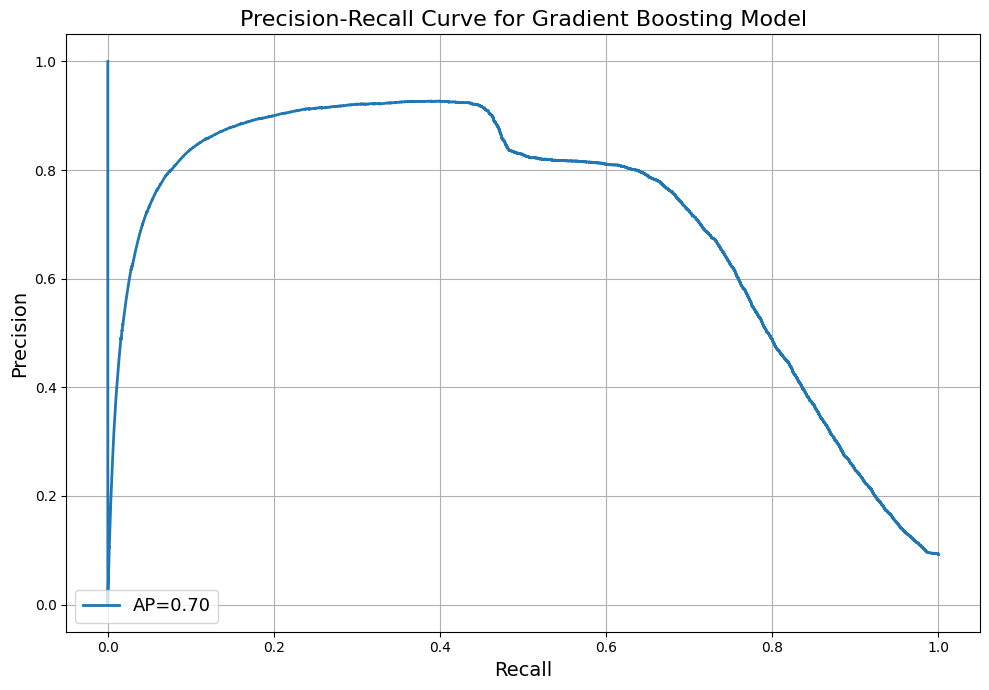

In [42]:
from sklearn.metrics import average_precision_score
y_scores_nb = gnb.predict_proba(X_test)[:, 1]

# Compute precision-recall curve values
precision, recall, _ = precision_recall_curve(y_test, y_scores_nb)

# Compute the average precision score
avg_precision = average_precision_score(y_test, y_scores_nb)

# Plot the precision-recall curve
plt.figure(figsize=(10, 7))
plt.plot(recall, precision, label=f'AP={avg_precision:.2f}', lw=2)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve for Gradient Boosting Model', fontsize=16)
plt.legend(loc='lower left', fontsize=13)
plt.grid(True)
plt.tight_layout()
plt.show()

The optimal number of neighbors is 2


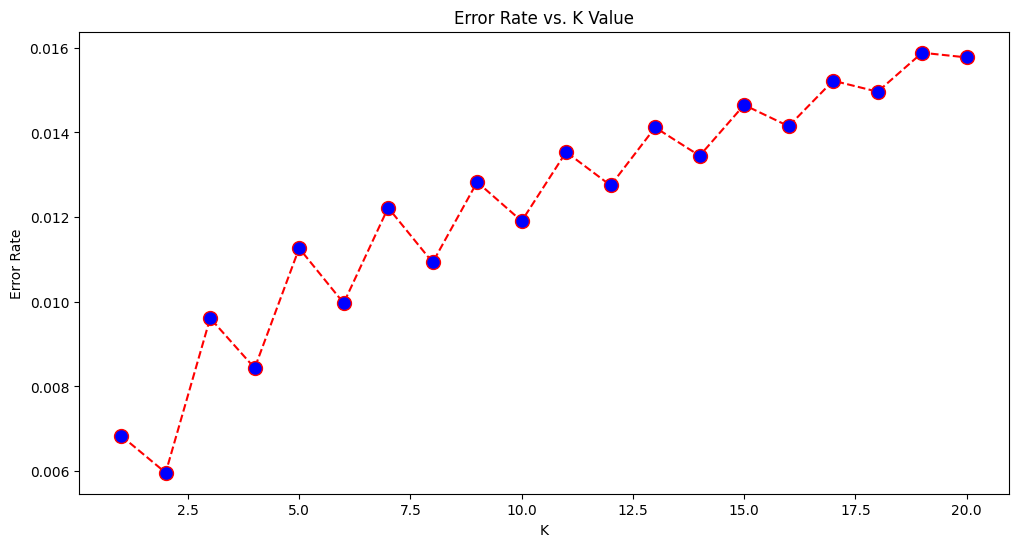

K-Nearest Neighbors Training Data Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    442985
           1       1.00      1.00      1.00     44159

    accuracy                           1.00    487144
   macro avg       1.00      1.00      1.00    487144
weighted avg       1.00      1.00      1.00    487144

K-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    110589
           1       0.96      0.99      0.97     11198

    accuracy                           1.00    121787
   macro avg       0.98      0.99      0.99    121787
weighted avg       1.00      1.00      1.00    121787

Confusion Matrix:
 [[110100    489]
 [    91  11107]]


In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Determine the optimal number of neighbors
neighbors = list(range(1, 21))  # Checking for k from 1 to 20, you can adjust this range as needed
cv_scores_knn = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')  # using 5-fold cross validation
    cv_scores_knn.append(scores.mean())

# Plotting the misclassification error vs k
MSE = [1 - x for x in cv_scores_knn]
optimal_k = neighbors[MSE.index(min(MSE))]
print(f"The optimal number of neighbors is {optimal_k}")

plt.figure(figsize=(12, 6))
plt.plot(neighbors, MSE, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()

# Initialize the KNN classifier with the optimal number of neighbors
knn_model = KNeighborsClassifier(n_neighbors=optimal_k)
knn_model.fit(X_train, y_train)

# Evaluate model on training data to check for overfitting
y_train_pred_knn = knn_model.predict(X_train)

print("K-Nearest Neighbors Training Data Performance:")
print(classification_report(y_train, y_train_pred_knn))

# Predict on the test set
y_pred_knn = knn_model.predict(X_test)

# Print classification report
print("K-Nearest Neighbors Classification Report:")
print(classification_report(y_test, y_pred_knn))

# Confusion matrix
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
print("Confusion Matrix:\n", conf_matrix_knn)


In [18]:
# Make predictions using the trained logistic regression model
predicted_class_knn = knn_model.predict(new_data)
print(predicted_class)
# Map the predicted class to a meaningful label (fraud or not fraud)
predicted_label_knn = 'Fraud' if predicted_class[0] == 1 else 'Not Fraud'

# Print the prediction result
print("Predicted Label for the New Transaction:", predicted_label_knn)

[0]
Predicted Label for the New Transaction: Not Fraud


[[109800    747]
 [     6  77662]]


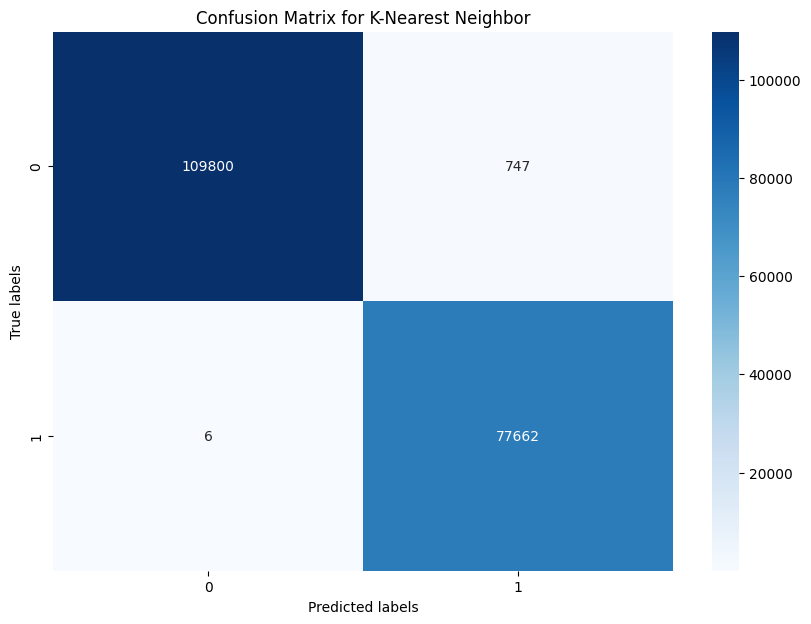

In [19]:
# Confusion matrix plot

conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
print(conf_matrix_knn)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_knn, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for K-Nearest Neighbor')
plt.show()
